<a href="https://colab.research.google.com/github/saqlineniam/Real-Time-Apple-Detection-for-Robust-Multi-Object-Tracking-in-Orchard-Environments/blob/main/Apple_tracking_with_YOLOv8_%2B_KalmanFilter%2B_BotSort_%2B_LoFTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# CELL 1: Install Dependencies
# ============================================================================
!pip install torch torchvision kornia opencv-python matplotlib scipy -q
!pip install ultralytics filterpy lap scikit-learn -q

print("✅ All dependencies installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 103.0 MB/s eta 0:00:00
✅ All dependencies installed!


In [ ]:
# ============================================================================
# CELL 2: Import Libraries
# ============================================================================
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import os
from collections import defaultdict, deque
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, field
from scipy.optimize import linear_sum_assignment
import kornia as K
import kornia.feature as KF
from tqdm import tqdm
import warnings
import pickle
from filterpy.kalman import KalmanFilter
import lap  # For linear assignment problem (faster than scipy)

warnings.filterwarnings('ignore')

print("✅ Libraries imported!")

✅ Libraries imported!


In [ ]:
# ============================================================================
# CELL 3: Kalman Filter for Motion Prediction
# ============================================================================
class KalmanBoxTracker:
    """
    Kalman Filter for tracking bounding box with constant velocity model
    State: [x, y, s, r, vx, vy, vs]
    Where: x,y = center, s = scale (area), r = aspect ratio
           vx, vy, vs = velocities
    """

    count = 0

    def __init__(self, bbox):
        """Initialize Kalman filter with detection bbox [x1, y1, x2, y2]"""
        # Define constant velocity model
        self.kf = KalmanFilter(dim_x=7, dim_z=4)

        # State transition matrix
        self.kf.F = np.array([
            [1,0,0,0,1,0,0],  # x = x + vx
            [0,1,0,0,0,1,0],  # y = y + vy
            [0,0,1,0,0,0,1],  # s = s + vs
            [0,0,0,1,0,0,0],  # r = r
            [0,0,0,0,1,0,0],  # vx = vx
            [0,0,0,0,0,1,0],  # vy = vy
            [0,0,0,0,0,0,1]   # vs = vs
        ])

        # Measurement function (we measure [x, y, s, r])
        self.kf.H = np.array([
            [1,0,0,0,0,0,0],
            [0,1,0,0,0,0,0],
            [0,0,1,0,0,0,0],
            [0,0,0,1,0,0,0]
        ])

        # Measurement uncertainty
        self.kf.R[2:,2:] *= 10.0  # Higher uncertainty for scale and ratio

        # Process uncertainty
        self.kf.P[4:,4:] *= 1000.0  # High uncertainty for velocities
        self.kf.P *= 10.0

        # Process noise
        self.kf.Q[-1,-1] *= 0.01
        self.kf.Q[4:,4:] *= 0.01

        # Initialize state
        self.kf.x[:4] = self._convert_bbox_to_z(bbox)

        self.time_since_update = 0
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count += 1
        self.history = []
        self.hits = 0
        self.hit_streak = 0
        self.age = 0

    def _convert_bbox_to_z(self, bbox):
        """Convert [x1,y1,x2,y2] to [x,y,s,r]"""
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        x = bbox[0] + w/2.0
        y = bbox[1] + h/2.0
        s = w * h  # scale (area)
        r = w / float(h)  # aspect ratio
        return np.array([x, y, s, r]).reshape((4, 1))

    def _convert_x_to_bbox(self, x):
        """Convert [x,y,s,r] to [x1,y1,x2,y2]"""
        w = np.sqrt(x[2] * x[3])
        h = x[2] / w
        return np.array([
            x[0] - w/2.0,
            x[1] - h/2.0,
            x[0] + w/2.0,
            x[1] + h/2.0
        ]).reshape((1, 4))

    def update(self, bbox):
        """Update state with new detection"""
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1
        self.kf.update(self._convert_bbox_to_z(bbox))

    def predict(self):
        """Predict next state"""
        if self.kf.x[6] + self.kf.x[2] <= 0:
            self.kf.x[6] *= 0.0
        self.kf.predict()
        self.age += 1
        if self.time_since_update > 0:
            self.hit_streak = 0
        self.time_since_update += 1
        self.history.append(self._convert_x_to_bbox(self.kf.x))
        return self.history[-1]

    def get_state(self):
        """Get current bounding box estimate"""
        return self._convert_x_to_bbox(self.kf.x)

    def apply_camera_motion(self, dx: float, dy: float):
      # Shift the state center (x, y) into the current frame using the background motion
      self.kf.x[0, 0] += dx
      self.kf.x[1, 0] += dy


print("✅ Kalman Filter defined!")

✅ Kalman Filter defined!


In [ ]:
# ============================================================================
# CELL 4: Data Structures
# ============================================================================
@dataclass
class Detection:
    """Single detection in a frame"""
    bbox: np.ndarray  # [x1, y1, x2, y2]
    score: float
    feature: Optional[np.ndarray] = None

    @property
    def center(self):
        return np.array([(self.bbox[0] + self.bbox[2])/2,
                        (self.bbox[1] + self.bbox[3])/2])

    @property
    def area(self):
        return (self.bbox[2] - self.bbox[0]) * (self.bbox[3] - self.bbox[1])


@dataclass
class Track:
    """Track with Kalman filter and feature memory"""
    track_id: int
    kf: KalmanBoxTracker
    features: deque = field(default_factory=lambda: deque(maxlen=30))
    global_positions: List[np.ndarray] = field(default_factory=list)
    detections_history: List[Detection] = field(default_factory=list)
    time_since_update: int = 0
    hits: int = 0
    age: int = 0
    state: str = 'tentative'  # tentative, confirmed, deleted

    def update(self, detection: Detection, global_pos: np.ndarray):
        """Update track with new detection"""
        self.kf.update(detection.bbox)
        if detection.feature is not None:
            self.features.append(detection.feature)
        self.global_positions.append(global_pos)
        self.detections_history.append(detection)
        self.time_since_update = 0
        self.hits += 1
        self.age += 1

        if self.state == 'tentative' and self.hits >= 2:
            self.state = 'confirmed'

    def predict(self):
        """Predict next position"""
        self.kf.predict()
        self.age += 1
        self.time_since_update += 1

    def mark_missed(self):
        """Mark as missed"""
        if self.state == 'tentative':
            self.state = 'deleted'
        elif self.time_since_update > 30:
            self.state = 'deleted'

    @property
    def bbox(self):
        """Get current bounding box"""
        return self.kf.get_state()[0]

print("✅ Data structures defined!")


✅ Data structures defined!


In [ ]:
# ============================================================================
# CELL 5: LoFTR Camera Motion Tracker
# ============================================================================
class LoFTRCameraTracker:
    """Track camera motion using LoFTR feature matching"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print(f"🔧 Initializing LoFTR on {device}...")

        self.matcher = KF.LoFTR(pretrained='outdoor').to(device).eval()
        self.global_position = np.array([0.0, 0.0])
        self.prev_frame = None
        self.last_delta = np.array([0.0, 0.0])


        print("✅ LoFTR initialized!")

    def estimate_camera_motion(self, frame: np.ndarray) -> np.ndarray:
        """Estimate camera motion from previous frame"""
        if self.prev_frame is None:
            self.prev_frame = frame.copy()
            return self.global_position.copy()

        # Convert to grayscale
        gray1 = cv2.cvtColor(self.prev_frame, cv2.COLOR_BGR2GRAY) if len(self.prev_frame.shape) == 3 else self.prev_frame
        gray2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) if len(frame.shape) == 3 else frame

        # Convert to torch tensors
        img1_t = K.image_to_tensor(gray1, False).float() / 255.0
        img2_t = K.image_to_tensor(gray2, False).float() / 255.0

        img1_t = img1_t.to(self.device)
        img2_t = img2_t.to(self.device)

        # Match with LoFTR
        with torch.no_grad():
            input_dict = {"image0": img1_t, "image1": img2_t}
            correspondences = self.matcher(input_dict)

        kpts1 = correspondences['keypoints0'].cpu().numpy()
        kpts2 = correspondences['keypoints1'].cpu().numpy()

        if len(kpts1) >= 4:
            H, mask = cv2.findHomography(kpts1, kpts2, cv2.RANSAC, 5.0)
            if H is not None:
                dx = H[0, 2]
                dy = H[1, 2]
                self.global_position += np.array([dx, dy])

        self.prev_frame = frame.copy()
        return self.global_position.copy()
        # after H is found
        if H is not None:
            dx = H[0, 2]
            dy = H[1, 2]
            self.last_delta = np.array([dx, dy], dtype=np.float32)
            self.global_position += self.last_delta
        else:
            self.last_delta = np.array([0.0, 0.0], dtype=np.float32)


    def to_global_coords(self, local_point: np.ndarray) -> np.ndarray:
        """Convert local coordinates to global"""
        return local_point + self.global_position

    def reset(self):
        """Reset for new sequence"""
        self.global_position = np.array([0.0, 0.0])
        self.prev_frame = None
        self.last_delta = np.array([0.0, 0.0])


print("✅ LoFTR camera tracker defined!")

✅ LoFTR camera tracker defined!


In [ ]:
# ============================================================================
# CELL 6: Feature Extractor for Re-ID
# ============================================================================
class FeatureExtractor:
    """Extract visual features using ResNet50"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print("🎨 Initializing feature extractor...")

        # Use ResNet50 backbone
        from torchvision.models import resnet50, ResNet50_Weights
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1]).to(device).eval()


        self.transform = T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        print("✅ Feature extractor ready!")

    def extract(self, frame: np.ndarray, bbox: np.ndarray) -> np.ndarray:
        """Extract features from bounding box region"""
        x1, y1, x2, y2 = bbox.astype(int)

        h, w = frame.shape[:2]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)

        if x2 <= x1 or y2 <= y1:
            return np.zeros(2048)

        crop = frame[y1:y2, x1:x2]
        if crop.size == 0:
            return np.zeros(2048)

        img_tensor = self.transform(crop).unsqueeze(0).to(self.device)

        with torch.no_grad():
            features = self.backbone(img_tensor)

        features = features.squeeze().cpu().numpy()
        # Normalize
        norm = np.linalg.norm(features)
        if norm > 0:
            features = features / norm

        return features

    def batch_extract(self, frame: np.ndarray, bboxes: List[np.ndarray]) -> List[np.ndarray]:
        """Extract features for multiple bboxes"""
        return [self.extract(frame, bbox) for bbox in bboxes]

print("✅ Feature extractor defined!")


✅ Feature extractor defined!


In [ ]:
# ============================================================================
# CELL 7: Apple Detector (YOLOv8)
# ============================================================================
class AppleDetector:
    """YOLOv8-based apple detector"""

    def __init__(self, model_path: str):
        print(f"📦 Loading YOLOv8 from {model_path}...")
        from ultralytics import YOLO
        self.model = YOLO(model_path)
        print("✅ Detector loaded!")

    def detect(self, frame: np.ndarray) -> List[Detection]:
        """Detect apples in frame"""
        results = self.model.predict(frame, conf=0.25, imgsz=640, verbose=False)


        detections = []
        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes.data.cpu().numpy()

            for box in boxes:
                x1, y1, x2, y2, score, cls = box
                detection = Detection(
                    bbox=np.array([x1, y1, x2, y2]),
                    score=float(score)
                )
                detections.append(detection)

        return detections

print("✅ Detector defined!")

✅ Detector defined!


In [ ]:
# ============================================================================
# CELL 8: Association Functions
# ============================================================================
def iou_batch(bboxes1: np.ndarray, bboxes2: np.ndarray) -> np.ndarray:
    """
    Compute IoU between two sets of bounding boxes
    bboxes1: (N, 4) array
    bboxes2: (M, 4) array
    Returns: (N, M) IoU matrix
    """
    bboxes2 = np.expand_dims(bboxes2, 0)
    bboxes1 = np.expand_dims(bboxes1, 1)

    xx1 = np.maximum(bboxes1[..., 0], bboxes2[..., 0])
    yy1 = np.maximum(bboxes1[..., 1], bboxes2[..., 1])
    xx2 = np.minimum(bboxes1[..., 2], bboxes2[..., 2])
    yy2 = np.minimum(bboxes1[..., 3], bboxes2[..., 3])

    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)

    intersection = w * h
    area1 = (bboxes1[..., 2] - bboxes1[..., 0]) * (bboxes1[..., 3] - bboxes1[..., 1])
    area2 = (bboxes2[..., 2] - bboxes2[..., 0]) * (bboxes2[..., 3] - bboxes2[..., 1])
    union = area1 + area2 - intersection

    iou = intersection / np.maximum(union, 1e-6)

    return iou


def embedding_distance(features1: List[np.ndarray], features2: List[np.ndarray]) -> np.ndarray:
    """
    Compute cosine distance between feature embeddings
    Returns: (N, M) distance matrix
    """
    if not features1 or not features2:
        return np.zeros((len(features1) if features1 else 0,
                        len(features2) if features2 else 0))

    feat1 = np.array(features1)
    feat2 = np.array(features2)

    # Cosine similarity
    similarity = np.dot(feat1, feat2.T)

    # Convert to distance
    distance = 1.0 - similarity

    return distance


def linear_assignment(cost_matrix: np.ndarray, thresh: float) -> Tuple[np.ndarray, List[int], List[int]]:
    """
    Perform linear assignment with threshold
    Returns: matches, unmatched_a, unmatched_b
    """
    if cost_matrix.size == 0:
        return np.empty((0, 2), dtype=int), list(range(cost_matrix.shape[0])), list(range(cost_matrix.shape[1]))

    # Use lap for faster assignment
    cost, x, y = lap.lapjv(cost_matrix, extend_cost=True, cost_limit=thresh)

    matches = []
    unmatched_a = []
    unmatched_b = []

    for i, j in enumerate(x):
        if j >= 0 and cost_matrix[i, j] < thresh:
            matches.append([i, j])
        else:
            unmatched_a.append(i)

    for j in range(cost_matrix.shape[1]):
        if j not in x:
            unmatched_b.append(j)

    return np.array(matches), unmatched_a, unmatched_b

print("✅ Association functions defined!")


✅ Association functions defined!


In [ ]:
# ============================================================================
# CELL 9: BoT-SORT Tracker
# ============================================================================
class BoTSORT:
    """
    BoT-SORT: ByteTrack + Bag of Tricks for Multi-Object Tracking
    With LoFTR-based global re-association
    """

    def __init__(
        self,
        detector_path: str,
        track_high_thresh: float = 0.6,
        track_low_thresh: float = 0.1,
        new_track_thresh: float = 0.7,
        match_thresh: float = 0.8,
        max_time_lost: int = 30,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    ):
        print("🚀 Initializing BoT-SORT Tracking System...")

        # Components
        self.detector = AppleDetector(detector_path)
        self.feature_extractor = FeatureExtractor(device)
        self.camera_tracker = LoFTRCameraTracker(device)

        # Parameters
        self.track_high_thresh = track_high_thresh
        self.track_low_thresh = track_low_thresh
        self.new_track_thresh = new_track_thresh
        self.match_thresh = match_thresh
        self.max_time_lost = max_time_lost

        # State
        self.tracked_tracks: List[Track] = []
        self.lost_tracks: List[Track] = []
        self.removed_tracks: List[Track] = []
        self.frame_id = 0
        self.next_id = 0

        print("✅ BoT-SORT initialized!")

    def update(self, frame: np.ndarray) -> List[Track]:
        """
        Main tracking update for one frame
        Implements full BoT-SORT pipeline
        """
        self.frame_id += 1

        # Step 1: Estimate camera motion with LoFTR
        camera_pos = self.camera_tracker.estimate_camera_motion(frame)
        # --- Camera Motion Compensation: shift all active/lost tracks into current frame ---
        dx, dy = float(self.camera_tracker.last_delta[0]), float(self.camera_tracker.last_delta[1])
        if dx != 0.0 or dy != 0.0:
            for t in (self.tracked_tracks + self.lost_tracks):
                t.kf.apply_camera_motion(dx, dy)
        # -------------------------------------------------------------------------------


        # Step 2: Get detections from YOLOv8
        all_detections = self.detector.detect(frame)

        # Step 3: Split detections by confidence (ByteTrack strategy)
        high_detections = [d for d in all_detections if d.score >= self.track_high_thresh]
        low_detections = [d for d in all_detections if self.track_low_thresh <= d.score < self.track_high_thresh]
        # Optional but helpful: get features for low detections too
        if low_detections:
            low_bboxes = [d.bbox for d in low_detections]
            low_features = self.feature_extractor.batch_extract(frame, low_bboxes)
            for det, feat in zip(low_detections, low_features):
                det.feature = feat


        # Step 4: Extract features for high-confidence detections
        if high_detections:
            high_bboxes = [d.bbox for d in high_detections]
            features = self.feature_extractor.batch_extract(frame, high_bboxes)
            for det, feat in zip(high_detections, features):
                det.feature = feat

        # Step 5: Prediction - Predict next position for all tracks
        for track in self.tracked_tracks:
            track.predict()

        # Combine tracked and lost tracks for matching
        track_pool = self.tracked_tracks + self.lost_tracks

        # Step 6: First Association - Match with high-confidence detections
        matches, unmatched_tracks, unmatched_dets = self._first_association(
            track_pool, high_detections, frame, camera_pos
        )

        # Update matched tracks
        for track_idx, det_idx in matches:
            track = track_pool[track_idx]
            detection = high_detections[det_idx]
            global_pos = self.camera_tracker.to_global_coords(detection.center)
            track.update(detection, global_pos)

        # Step 7: Second Association - Match remaining tracks with low-confidence detections
        remaining_tracks = [track_pool[i] for i in unmatched_tracks]
        matches_low, unmatched_tracks_low, unmatched_dets_low = self._second_association(
            remaining_tracks, low_detections, frame, camera_pos
        )

        # Update matched tracks from second association
        for track_idx, det_idx in matches_low:
            track = remaining_tracks[track_idx]
            detection = low_detections[det_idx]
            global_pos = self.camera_tracker.to_global_coords(detection.center)
            track.update(detection, global_pos)

        # Step 8: Handle unmatched tracks
        for i in unmatched_tracks_low:
            track = remaining_tracks[i]
            track.mark_missed()

        # Step 9: Global Re-association (Paper's contribution!)
        unmatched_high_dets = [high_detections[i] for i in unmatched_dets]
        new_tracks = self._global_re_association(unmatched_high_dets, camera_pos)

        # Step 10: Track management
        self.tracked_tracks = [t for t in track_pool if t.state == 'confirmed' and t.time_since_update == 0]
        self.lost_tracks = [t for t in track_pool if t.state == 'confirmed' and t.time_since_update > 0 and t.time_since_update <= self.max_time_lost]
        self.removed_tracks.extend([t for t in track_pool if t.state == 'deleted' or t.time_since_update > self.max_time_lost])

        # Add new tracks
        self.tracked_tracks.extend(new_tracks)

        return [t for t in self.tracked_tracks if t.state == 'confirmed']

    def _first_association(
        self,
        tracks: List[Track],
        detections: List[Detection],
        frame: np.ndarray,
        camera_pos: np.ndarray
    ) -> Tuple[np.ndarray, List[int], List[int]]:
        if len(tracks) == 0 or len(detections) == 0:
            return np.empty((0, 2), dtype=int), list(range(len(tracks))), list(range(len(detections)))

        track_bboxes = np.array([t.bbox for t in tracks])
        det_bboxes = np.array([d.bbox for d in detections])

        # IoU cost
        iou_matrix = iou_batch(track_bboxes, det_bboxes)
        iou_cost = 1.0 - iou_matrix

        # Prepare features (None when unavailable)
        track_feats = []
        for t in tracks:
            if len(t.features) > 0:
                track_feats.append(np.mean(list(t.features)[-5:], axis=0))
            else:
                track_feats.append(None)

        det_feats = [d.feature if (d.feature is not None and d.feature.size > 0 and np.any(d.feature)) else None
                    for d in detections]

        # Appearance cost: start as "no penalty" (same shape as iou)
        appearance_cost = np.ones_like(iou_cost) * 0.5  # neutral mid-cost

        # Fill where both features exist
        for i, tf in enumerate(track_feats):
            for j, df in enumerate(det_feats):
                if tf is not None and df is not None:
                    sim = float(np.dot(tf, df))  # cosine sim because both are L2-normalized
                    appearance_cost[i, j] = 1.0 - sim  # distance in [0,2], typically [0,1]

        # Blend with higher IoU weight early on (appearance unreliable for tentative tracks)
        # Tip: downweight appearance for tentative tracks
        alpha_iou = 0.85
        cost_matrix = alpha_iou * iou_cost + (1.0 - alpha_iou) * appearance_cost

        # Stricter gate on IoU itself (small sanity gate helps)
        gate = (iou_matrix < 0.01)  # practically no overlap -> block
        cost_matrix = np.where(gate, 1e6, cost_matrix)

        matches, unmatched_tracks, unmatched_dets = linear_assignment(cost_matrix, self.match_thresh)
        return matches, unmatched_tracks, unmatched_dets

    def _second_association(
        self,
        tracks: List[Track],
        detections: List[Detection],
        frame: np.ndarray,
        camera_pos: np.ndarray
    ) -> Tuple[np.ndarray, List[int], List[int]]:
        """
        Second association: Low-confidence detections with IoU only
        """
        if len(tracks) == 0 or len(detections) == 0:
            return np.empty((0, 2), dtype=int), list(range(len(tracks))), list(range(len(detections)))

        track_bboxes = np.array([t.bbox for t in tracks])
        det_bboxes = np.array([d.bbox for d in detections])

        iou_matrix = iou_batch(track_bboxes, det_bboxes)
        iou_cost = 1.0 - iou_matrix

        # More lenient threshold for second association
        matches, unmatched_tracks, unmatched_dets = linear_assignment(iou_cost, 0.7)  # ≈ IoU > 0.3


        return matches, unmatched_tracks, unmatched_dets

    def _global_re_association(
        self,
        unmatched_detections: List[Detection],
        camera_pos: np.ndarray
    ) -> List[Track]:
        """
        Global re-association using spatial proximity
        This is the key contribution from the paper!
        """
        new_tracks = []

        for detection in unmatched_detections:
            if detection.score < self.new_track_thresh:
                continue

            # Calculate global position
            global_pos = self.camera_tracker.to_global_coords(detection.center)

            # Check against lost tracks
            re_associated = False

            for lost_track in self.lost_tracks:
                if len(lost_track.global_positions) == 0:
                    continue

                # Calculate distance in global coordinates
                last_global_pos = lost_track.global_positions[-1]
                distance = np.linalg.norm(global_pos - last_global_pos)

                # Check appearance similarity if features available
                appearance_match = True
                if detection.feature is not None and len(lost_track.features) > 0:
                    avg_feature = np.mean(list(lost_track.features)[-5:], axis=0)
                    feat_distance = 1.0 - np.dot(detection.feature, avg_feature)
                    appearance_match = feat_distance < 0.5

                # Re-associate if close enough in space and appearance
                if distance < 100 and appearance_match:  # 100 pixels threshold
                    lost_track.update(detection, global_pos)
                    lost_track.time_since_update = 0
                    self.lost_tracks.remove(lost_track)
                    new_tracks.append(lost_track)
                    re_associated = True
                    break

            # Create new track if not re-associated
            if not re_associated:
                kf = KalmanBoxTracker(detection.bbox)
                new_track = Track(
                    track_id=self.next_id,
                    kf=kf
                )
                new_track.update(detection, global_pos)
                new_tracks.append(new_track)
                self.next_id += 1

        return new_tracks

    def reset(self):
        """Reset tracker for new sequence"""
        self.tracked_tracks = []
        self.lost_tracks = []
        self.removed_tracks = []
        self.frame_id = 0
        self.next_id = 0
        self.camera_tracker.reset()
        KalmanBoxTracker.count = 0

print("✅ BoT-SORT tracker defined!")

✅ BoT-SORT tracker defined!


In [ ]:
# ============================================================================
# CELL 10: Sequence Data Loader (Modified for YOLO COCO style)
# ============================================================================
class YOLOCocoSequenceLoader:
    """Load dataset organized in YOLO COCO style"""

    def __init__(self, dataset_root: str):
        self.dataset_root = Path(dataset_root)
        self.sequences = {}
        self._organize_sequences()

    def _organize_sequences(self):
        """Organize frames into sequences (assuming YOLO COCO style)"""
        print("📂 Organizing dataset into sequences (YOLO COCO style)...")

        # Assuming a structure like dataset_root / {train, val, test} / {images, labels}
        for split in ['train', 'val']: # Assuming standard splits
            img_dir = self.dataset_root / 'images' / split

            if not img_dir.exists():
                print(f"   Skipping split '{split}': Image directory not found at {img_dir}")
                continue

            image_files = sorted([f for f in img_dir.iterdir() if f.suffix.lower() in ['.png', '.jpg', '.jpeg']])

            if not image_files:
                print(f"   No images found in {img_dir}")
                continue

            # For YOLO COCO style, each image is typically treated as a single frame sequence
            # Or, if frames are sequentially named, they can be grouped into a sequence.
            # Let's assume sequential naming for now to maintain sequence concept.
            # If frames are not sequential, each image can be its own sequence of 1 frame.

            current_seq = []
            seq_id = 0
            prev_num = -1 # To detect sequence breaks based on file naming

            for img_file in image_files:
                try:
                    # Attempt to extract a frame number from the filename
                    # This might need customization based on your exact naming
                    frame_num_str = ''.join(filter(str.isdigit, img_file.stem))
                    frame_num = int(frame_num_str) if frame_num_str else len(current_seq) # Use index if no number

                    if prev_num != -1 and frame_num - prev_num > 1:
                         # Sequence break detected
                         if current_seq:
                             seq_name = f"{split}_seq{seq_id:03d}" # Use 3 digits for seq ID
                             self.sequences[seq_name] = current_seq
                             seq_id += 1
                         current_seq = []

                    current_seq.append({
                        'image': str(img_file),
                        'frame_id': len(current_seq), # Frame ID within this sequence
                        'label': str(self.dataset_root / 'labels' / split / (img_file.stem + '.txt'))

                    })
                    prev_num = frame_num

                except ValueError:
                    # If filename doesn't contain a number, treat each image as a sequence of 1
                    if current_seq: # Save previous sequence if any
                        seq_name = f"{split}_seq{seq_id:03d}"
                        self.sequences[seq_name] = current_seq
                        seq_id += 1
                    current_seq = [{
                         'image': str(img_file),
                         'frame_id': 0,
                         'label': str(self.dataset_root / 'labels' / split / (img_file.stem + '.txt'))

                    }]
                    seq_name = f"{split}_seq{seq_id:03d}"
                    self.sequences[seq_name] = current_seq
                    seq_id += 1
                    current_seq = [] # Reset for next image

            # Add the last sequence
            if current_seq:
                seq_name = f"{split}_seq{seq_id:03d}"
                self.sequences[seq_name] = current_seq


        print(f"✅ Found {len(self.sequences)} sequences:")
        for seq_name, frames in self.sequences.items():
            print(f"   {seq_name}: {len(frames)} frames")

    def get_sequence(self, seq_name: str):
        return self.sequences.get(seq_name, [])

    def get_all_sequences(self):
        return list(self.sequences.keys())

print("✅ Sequence loader defined (YOLO COCO style)!")

✅ Sequence loader defined (YOLO COCO style)!


In [ ]:
# ============================================================================
# CELL 11: Visualization Functions
# ============================================================================
def visualize_tracking(
    sequence_frames: List[Dict],
    all_frame_tracks: List[List[Track]],
    output_dir: str,
    max_frames: int = 100
):
    """Create visualization of tracking results"""
    print(f"\n🎨 Creating visualizations...")

    os.makedirs(output_dir, exist_ok=True)

    np.random.seed(42)
    colors = {}

    for frame_idx, tracks in enumerate(all_frame_tracks[:max_frames]):
        if frame_idx >= len(sequence_frames):
            break

        frame_path = sequence_frames[frame_idx]['image']
        frame = cv2.imread(frame_path)

        if frame is None:
            continue

        for tr in tracks:
            tid = tr['track_id']
            bbox = tr['bbox']
            if tid not in colors:
                colors[tid] = tuple(np.random.randint(50, 255, 3).tolist())
            color = colors[tid]

            x1, y1, x2, y2 = bbox.astype(int)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

            label = f"ID:{tid}"
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(frame, (x1, y1-th-8), (x1+tw+4, y1), color, -1)
            cv2.putText(frame, label, (x1+2, y1-4),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        info = f"Frame {frame_idx} | Tracks: {len(tracks)}"
        cv2.putText(frame, info, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

        output_path = os.path.join(output_dir, f'frame_{frame_idx:06d}.jpg')
        cv2.imwrite(output_path, frame)

    print(f"✅ Saved {min(max_frames, len(all_frame_tracks))} frames")


def create_tracking_video(
    sequence_frames: List[Dict],
    all_frame_tracks: List[List[Track]],
    output_path: str,
    fps: int = 10
):
    """Create tracking video"""
    print(f"\n🎬 Creating tracking video...")

    if not sequence_frames:
        return

    first_frame = cv2.imread(sequence_frames[0]['image'])
    h, w = first_frame.shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    np.random.seed(42)
    colors = {}
    track_history = defaultdict(lambda: deque(maxlen=30))

    for frame_idx, tracks in enumerate(tqdm(all_frame_tracks, desc="Creating video")):
        if frame_idx >= len(sequence_frames):
            break

        frame = cv2.imread(sequence_frames[frame_idx]['image'])
        if frame is None:
            continue

        for tr in tracks:
            tid = tr['track_id']
            bbox = tr['bbox']

            if tid not in colors:
                colors[tid] = tuple(np.random.randint(50, 255, 3).tolist())
            color = colors[tid]

            center = ((bbox[0] + bbox[2])/2, (bbox[1] + bbox[3])/2)
            track_history[tid].append(center)

            # Draw trail
            if len(track_history[tid]) > 1:
                points = list(track_history[tid])
                for i in range(1, len(points)):
                    pt1 = tuple(map(int, points[i-1]))
                    pt2 = tuple(map(int, points[i]))
                    alpha = i / len(points)
                    thickness = max(1, int(3 * alpha))
                    cv2.line(frame, pt1, pt2, color, thickness)

            x1, y1, x2, y2 = bbox.astype(int)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

            label = f"ID:{tid}"
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(frame, (x1, y1-th-8), (x1+tw+4, y1), color, -1)
            cv2.putText(frame, label, (x1+2, y1-4),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        info = f"Frame: {frame_idx} | Tracks: {len(tracks)}"
        cv2.rectangle(frame, (10, 10), (450, 50), (0, 0, 0), -1)
        cv2.putText(frame, info, (20, 35),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        out.write(frame)

    out.release()
    print(f"✅ Video saved to {output_path}")


def plot_global_trajectories(all_frame_tracks, output_path):
    print("\n📊 Plotting global trajectories (screen coords, snapshots)...")
    traj = defaultdict(list)
    for tracks in all_frame_tracks:
        for tr in tracks:
            tid = tr['track_id']
            x1,y1,x2,y2 = tr['bbox']
            cx, cy = (x1+x2)/2, (y1+y2)/2
            traj[tid].append((cx, cy))
    ...


    plt.figure(figsize=(15, 10))

    for track_id, positions in track_trajectories.items():
        if len(positions) < 2:
            continue
        positions = np.array(positions)
        plt.plot(positions[:, 0], positions[:, 1], 'o-', alpha=0.6, label=f'ID {track_id}')
        plt.plot(positions[0, 0], positions[0, 1], 'go', markersize=10)
        plt.plot(positions[-1, 0], positions[-1, 1], 'ro', markersize=10)

    plt.xlabel('Global X (pixels)', fontsize=14)
    plt.ylabel('Global Y (pixels)', fontsize=14)
    plt.title('Global Apple Trajectories', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Trajectory plot saved")

print("✅ Visualization functions defined!")

✅ Visualization functions defined!


In [ ]:
# ============================================================================
# CELL 12: Initialize System
# ============================================================================
# Define paths
DATASET_ROOT = "/content/drive/MyDrive/AppleMOT_YOLOv8_CBAM"
MODEL_PATH = "/content/drive/MyDrive/YOLOv8_Apple_Training_CBAM/apple_segmentation_cbam4/weights/best.pt"
OUTPUT_DIR = "/content/drive/MyDrive/BoTSORT_Results"

# Load sequences
print("\n" + "="*70)
print("🚀 INITIALIZING BOT-SORT SYSTEM")
print("="*70)

loader = YOLOCocoSequenceLoader(DATASET_ROOT)
sequences = loader.get_all_sequences()

print(f"\n📋 Available sequences: {sequences}")



🚀 INITIALIZING BOT-SORT SYSTEM
📂 Organizing dataset into sequences (YOLO COCO style)...
✅ Found 13 sequences:
   train_seq000: 71 frames
   train_seq001: 169 frames
   train_seq002: 119 frames
   train_seq003: 151 frames
   train_seq004: 486 frames
   train_seq005: 151 frames
   val_seq000: 101 frames
   val_seq001: 103 frames
   val_seq002: 322 frames
   val_seq003: 96 frames
   val_seq004: 4 frames
   val_seq005: 103 frames
   val_seq006: 322 frames

📋 Available sequences: ['train_seq000', 'train_seq001', 'train_seq002', 'train_seq003', 'train_seq004', 'train_seq005', 'val_seq000', 'val_seq001', 'val_seq002', 'val_seq003', 'val_seq004', 'val_seq005', 'val_seq006']


In [ ]:
# ============================================================================
# CELL 13: Run Tracking on Single Sequence
# ============================================================================
# Select sequence
SEQUENCE_NAME = sequences[4] if sequences else "train_seq00"
sequence_frames = loader.get_sequence(SEQUENCE_NAME)

print(f"\n🎯 Processing sequence: {SEQUENCE_NAME}")
print(f"   Total frames: {len(sequence_frames)}")

# Initialize tracker
tracker = BoTSORT(
    detector_path=MODEL_PATH,
    track_high_thresh=0.4,
    track_low_thresh=0.1,
    new_track_thresh=0.7,
    match_thresh=0.7,
    max_time_lost=30
)

# Process sequence
print(f"\n🎬 Running BoT-SORT tracking...")
all_frame_tracks = []

for frame_data in tqdm(sequence_frames, desc="Tracking"):
    frame = cv2.imread(frame_data['image'])
    if frame is None:
        continue

# OLD:
# confirmed_tracks = tracker.update(frame)
# all_frame_tracks.append(confirmed_tracks)

    # NEW (snapshot, not objects):
    confirmed_tracks = tracker.update(frame)
    frame_snapshot = [{'track_id': t.track_id, 'bbox': t.bbox.copy()} for t in confirmed_tracks]
    all_frame_tracks.append(frame_snapshot)

print(f"\n✅ Tracking complete!")
print(f"   Total unique tracks: {tracker.next_id}")
print(f"   Active tracks: {len(tracker.tracked_tracks)}")
print(f"   Lost tracks: {len(tracker.lost_tracks)}")



🎯 Processing sequence: train_seq004
   Total frames: 486
🚀 Initializing BoT-SORT Tracking System...
📦 Loading YOLOv8 from /content/drive/MyDrive/YOLOv8_Apple_Training_CBAM/apple_segmentation_cbam4/weights/best.pt...
✅ Detector loaded!
🎨 Initializing feature extractor...
✅ Feature extractor ready!
🔧 Initializing LoFTR on cuda...
✅ LoFTR initialized!
✅ BoT-SORT initialized!

🎬 Running BoT-SORT tracking...


Tracking: 100%|██████████| 486/486 [18:37<00:00,  2.30s/it]


✅ Tracking complete!
   Total unique tracks: 836
   Active tracks: 127
   Lost tracks: 2024


📂 Organizing dataset into sequences (YOLO COCO style)...
✅ Found 13 sequences:
   train_seq000: 71 frames
   train_seq001: 169 frames
   train_seq002: 119 frames
   train_seq003: 151 frames
   train_seq004: 486 frames
   train_seq005: 151 frames
   val_seq000: 101 frames
   val_seq001: 103 frames
   val_seq002: 322 frames
   val_seq003: 96 frames
   val_seq004: 4 frames
   val_seq005: 103 frames
   val_seq006: 322 frames
📦 Loading YOLOv8 from /content/drive/MyDrive/YOLOv8_Apple_Training_CBAM/apple_segmentation_cbam4/weights/best.pt...
✅ Detector loaded!

🔎 Testing detector on a single frame: /content/drive/MyDrive/AppleMOT_YOLOv8_CBAM/images/train/0002_000000.png

✅ Detector found 132 apples in the first frame.
   Scores of detected apples: ['0.92', '0.91', '0.91', '0.90', '0.89', '0.89', '0.88', '0.88', '0.88', '0.88', '0.88', '0.88', '0.88', '0.87', '0.87', '0.86', '0.86', '0.86', '0.86', '0.86', '0.85', '0.85', '0.85', '0.85', '0.84', '0.84', '0.83', '0.83', '0.82', '0.82', '0.82', 

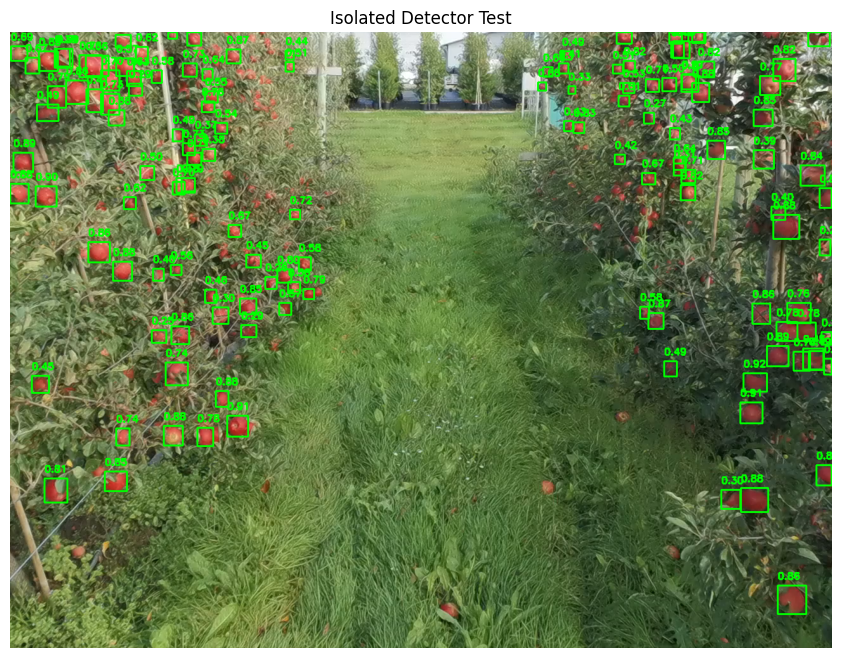

In [ ]:
# ============================================================================
# CELL 12.5: ISOLATED DETECTOR TEST
# ============================================================================
import cv2
import matplotlib.pyplot as plt

# Make sure your paths are correct, especially for Google Drive
DATASET_ROOT = "/content/drive/MyDrive/AppleMOT_YOLOv8_CBAM"
MODEL_PATH = "/content/drive/MyDrive/YOLOv8_Apple_Training_CBAM/apple_segmentation_cbam4/weights/best.pt"
# --- Setup ---
try:
    loader = YOLOCocoSequenceLoader(DATASET_ROOT)
    sequences = loader.get_all_sequences()

    if not sequences:
        raise ValueError("No sequences found by the loader. Check your DATASET_ROOT and data structure.")

    # Pick a sequence to test
    test_sequence_name = sequences[2]
    sequence_frames = loader.get_sequence(test_sequence_name)

    if not sequence_frames:
        raise ValueError(f"Sequence '{test_sequence_name}' is empty. Check your data.")

    # --- Test ---
    detector = AppleDetector(MODEL_PATH)

    # Test on the first frame of the sequence
    test_frame_path = sequence_frames[0]['image']
    print(f"\n🔎 Testing detector on a single frame: {test_frame_path}")

    frame = cv2.imread(test_frame_path)
    if frame is None:
        raise FileNotFoundError(f"Could not read the image file at: {test_frame_path}")

    detections = detector.detect(frame)

    # --- Verification ---
    print(f"\n✅ Detector found {len(detections)} apples in the first frame.")

    if not detections:
        print("🔴 CRITICAL ERROR: The detector found 0 objects.")
        print("   - Check your MODEL_PATH.")
        print("   - Ensure the model was trained correctly and can detect apples.")
        print("   - The `conf` threshold in `detector.detect` is already low (0.1), so that's likely not the issue.")
    else:
        print("   Scores of detected apples:", [f"{d.score:.2f}" for d in detections])

        # Visualize the detections to be sure
        for det in detections:
            x1, y1, x2, y2 = det.bbox.astype(int)
            score = det.score
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"{score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title("Isolated Detector Test")
        plt.axis('off')
        plt.show()

except Exception as e:
    print(f"\n❌ An error occurred during the isolated test: {e}")


📊 TRACKING ANALYSIS

Sequence: train_seq004
  Total Frames: 486
  Total Unique Tracks: 300
  Average Track Length: 237.51 frames
  Median Track Length:  46 frames
  Max Track Length:     5252 frames
  Min Track Length:     1 frames

Track Categories:
  Very Short (≤2 frames): 13 (4.3%)
  Short (3–10 frames):    44 (14.7%)
  Medium (11–50):         100 (33.3%)
  Long (>50):             143 (47.7%)


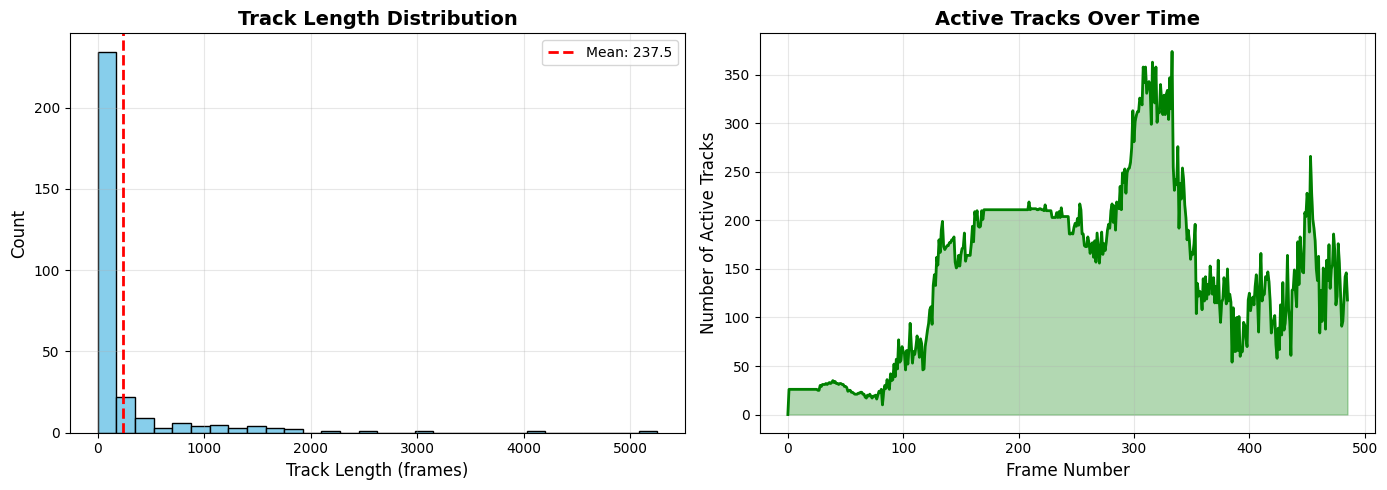


✅ Analysis saved to /content/drive/MyDrive/BoTSORT_Results/train_seq004_analysis.png


In [ ]:
# ============================================================================
# CELL 14: Analyze Results  (works with snapshots OR Track objects)
# ============================================================================
print("\n" + "="*70)
print("📊 TRACKING ANALYSIS")
print("="*70)

from collections import defaultdict
import numpy as np
import os
import matplotlib.pyplot as plt

track_lengths = defaultdict(int)
track_scores  = defaultdict(list)

# all_frame_tracks is List[List[track]], where each track is either:
#  - a dict snapshot: {'track_id', 'bbox', 'score'...}, or
#  - a Track object with .track_id and .detections_history
for frame_tracks in all_frame_tracks:
    for tr in frame_tracks:
        if isinstance(tr, dict):  # snapshot path
            tid   = tr['track_id']
            score = tr.get('score', 1.0)
        else:                      # Track object path
            tid   = tr.track_id
            score = (tr.detections_history[-1].score
                     if getattr(tr, 'detections_history', []) else 1.0)
        track_lengths[tid] += 1
        track_scores[tid].append(score)

if not track_lengths:
    print("⚠️ No confirmed tracks in snapshots—nothing to analyze.")
else:
    track_length_values = list(track_lengths.values())

    print(f"\nSequence: {SEQUENCE_NAME}")
    print(f"  Total Frames: {len(sequence_frames)}")
    print(f"  Total Unique Tracks: {len(track_lengths)}")
    print(f"  Average Track Length: {np.mean(track_length_values):.2f} frames")
    print(f"  Median Track Length:  {np.median(track_length_values):.0f} frames")
    print(f"  Max Track Length:     {max(track_length_values)} frames")
    print(f"  Min Track Length:     {min(track_length_values)} frames")

    # Track categories
    very_short  = sum(1 for l in track_length_values if l <= 2)
    short       = sum(1 for l in track_length_values if 3 <= l <= 10)
    medium      = sum(1 for l in track_length_values if 11 <= l <= 50)
    long_tracks = sum(1 for l in track_length_values if l > 50)

    print(f"\nTrack Categories:")
    denom = max(len(track_length_values), 1)
    print(f"  Very Short (≤2 frames): {very_short} ({very_short/denom*100:.1f}%)")
    print(f"  Short (3–10 frames):    {short} ({short/denom*100:.1f}%)")
    print(f"  Medium (11–50):         {medium} ({medium/denom*100:.1f}%)")
    print(f"  Long (>50):             {long_tracks} ({long_tracks/denom*100:.1f}%)")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(track_length_values, bins=30, color='skyblue', edgecolor='black')
    axes[0].set_xlabel('Track Length (frames)', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title('Track Length Distribution', fontsize=14, fontweight='bold')
    axes[0].axvline(np.mean(track_length_values), color='r', linestyle='--',
                    linewidth=2, label=f'Mean: {np.mean(track_length_values):.1f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    tracks_per_frame = [len(tracks) for tracks in all_frame_tracks]
    axes[1].plot(tracks_per_frame, linewidth=2, color='green')
    axes[1].fill_between(range(len(tracks_per_frame)), tracks_per_frame, alpha=0.3, color='green')
    axes[1].set_xlabel('Frame Number', fontsize=12)
    axes[1].set_ylabel('Number of Active Tracks', fontsize=12)
    axes[1].set_title('Active Tracks Over Time', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    analysis_path = os.path.join(OUTPUT_DIR, f'{SEQUENCE_NAME}_analysis.png')
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    plt.savefig(analysis_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Analysis saved to {analysis_path}")
    print("="*70)


In [ ]:
def plot_trajectories_from_snapshots(all_frame_tracks, output_path: str):
    """
    Build simple trajectories from per-frame snapshots:
    each track's trajectory is the sequence of bbox centers across frames.
    """
    from collections import defaultdict
    import numpy as np
    import matplotlib.pyplot as plt

    # track_id -> list of (x,y) centers (screen coords)
    traj = defaultdict(list)

    for frame_tracks in all_frame_tracks:
        for tr in frame_tracks:
            if isinstance(tr, dict):
                x1, y1, x2, y2 = tr['bbox']
            else:  # fallback if objects slip in
                x1, y1, x2, y2 = tr.bbox
            cx = 0.5 * (x1 + x2)
            cy = 0.5 * (y1 + y2)
            tid = tr['track_id'] if isinstance(tr, dict) else tr.track_id
            traj[tid].append((cx, cy))

    if not traj:
        print("⚠️ No trajectories to plot (no snapshots).")
        return

    plt.figure(figsize=(15, 10))
    for tid, pts in traj.items():
        if len(pts) < 2:
            continue
        pts = np.array(pts)
        plt.plot(pts[:, 0], pts[:, 1], 'o-', alpha=0.6, label=f'ID {tid}')
        plt.plot(pts[0, 0], pts[0, 1], 'go', markersize=8)   # start
        plt.plot(pts[-1, 0], pts[-1, 1], 'ro', markersize=8) # end

    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title('Track Trajectories (screen coordinates)')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=2)
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Trajectory plot saved to {output_path}")



🎨 Creating visualizations...
✅ Saved 100 frames

🎬 Creating tracking video...


Creating video: 100%|██████████| 486/486 [00:38<00:00, 12.72it/s]


✅ Video saved to /content/drive/MyDrive/BoTSORT_Results/train_seq004_tracking.mp4


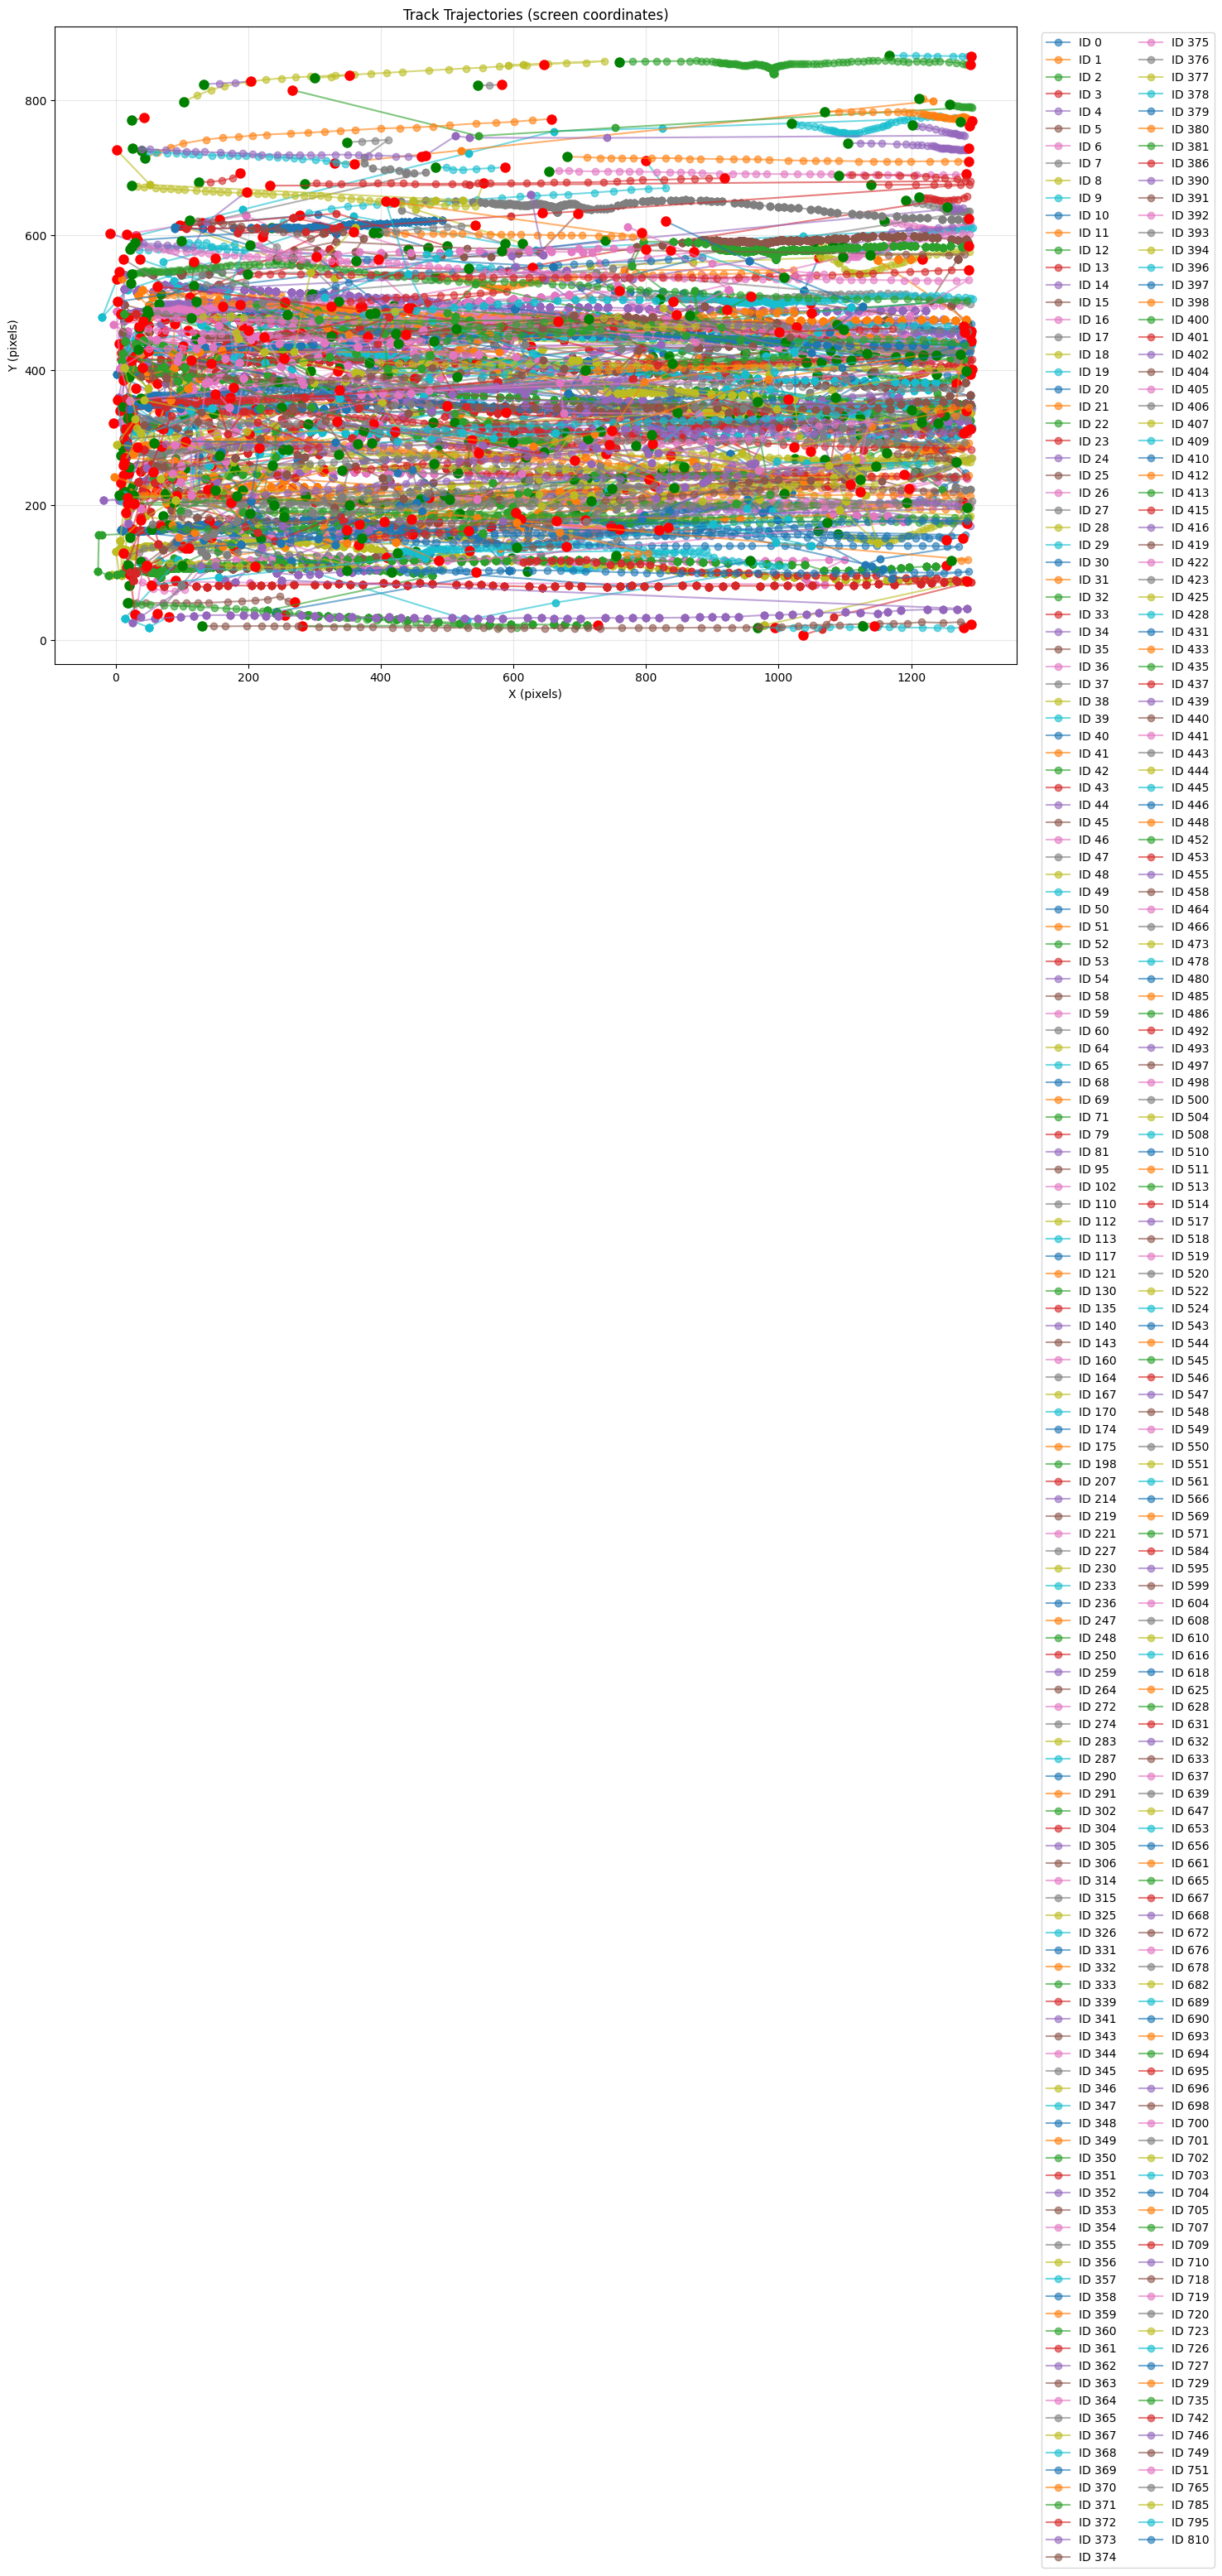

✅ Trajectory plot saved to /content/drive/MyDrive/BoTSORT_Results/train_seq004_trajectories.png
✅ Visualizations complete!


In [ ]:
# ============================================================================
# CELL 15: FIXED - Create Visualizations
# ============================================================================
# Create visualizations
vis_dir = os.path.join(OUTPUT_DIR, f'{SEQUENCE_NAME}_frames')
visualize_tracking(sequence_frames, all_frame_tracks, vis_dir, max_frames=100)

# Create video
video_path = os.path.join(OUTPUT_DIR, f'{SEQUENCE_NAME}_tracking.mp4')
create_tracking_video(sequence_frames, all_frame_tracks, video_path, fps=10)

# Plot trajectories - FIXED VERSION
traj_path = os.path.join(OUTPUT_DIR, f'{SEQUENCE_NAME}_trajectories.png')
plot_trajectories_from_snapshots(all_frame_tracks, traj_path)  # Use the correct function!

print("✅ Visualizations complete!")




In [ ]:
# ============================================================================
# CELL 16: FIXED - Export to MOT Format
# ============================================================================
def export_to_mot_format_fixed(all_frame_tracks: List, output_path: str):
    """Export to MOT challenge format"""
    print(f"\n📝 Exporting to MOT format...")

    with open(output_path, 'w') as f:  # MISSING with statement!
        for frame_id, tracks in enumerate(all_frame_tracks):
            for tr in tracks:
                bbox = tr['bbox']
                x, y = bbox[0], bbox[1]
                w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
                score = tr.get('score', 1.0)
                line = f"{frame_id+1},{tr['track_id']+1},{x:.2f},{y:.2f},{w:.2f},{h:.2f},{score:.3f},-1,-1,-1\n"
                f.write(line)

    print(f"✅ MOT format saved to {output_path}")


mot_path = os.path.join(OUTPUT_DIR, f'{SEQUENCE_NAME}_mot.txt')
export_to_mot_format_fixed(all_frame_tracks, mot_path)


📝 Exporting to MOT format...
✅ MOT format saved to /content/drive/MyDrive/BoTSORT_Results/train_seq001_mot.txt



🔍 COMPREHENSIVE TRACKING DIAGNOSIS

1️⃣ Testing Raw Detection Quality...
📦 Loading YOLOv8 from /content/drive/MyDrive/YOLOv8_Apple_Training_CBAM/apple_segmentation_cbam4/weights/best.pt...
✅ Detector loaded!
   Frame 0 detections: 116
   Score range: 0.255 - 0.924
   High conf (>0.6): 87
   Mid conf (0.3-0.6): 23
   Low conf (<0.3): 6


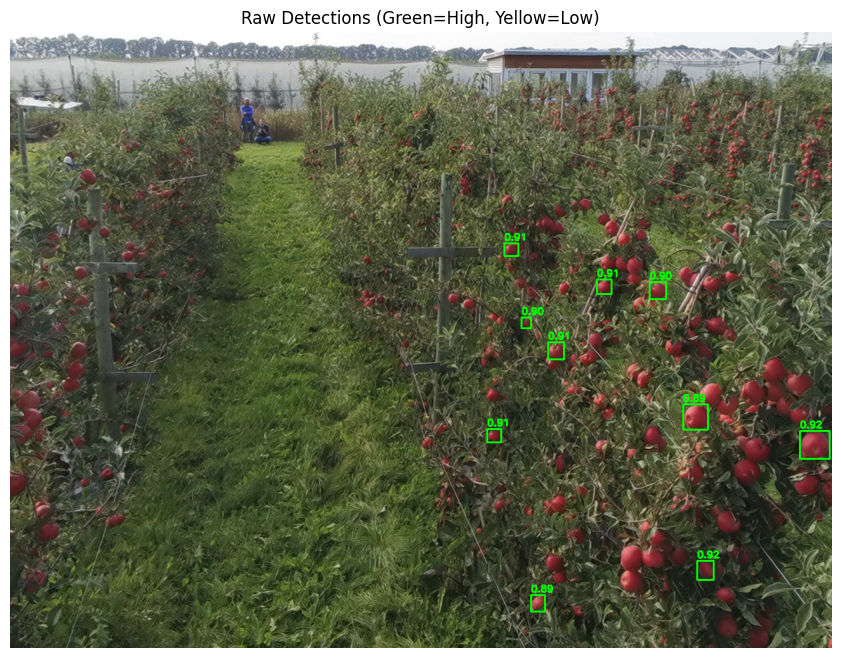


2️⃣ Testing Detection Consistency...
   Frames 0-19:
   Avg detections: 109.5
   Std dev: 5.6
   Range: 99 - 117
   ⚠️ HIGH VARIANCE - Unstable detection!

3️⃣ Checking Tracking Parameters...
   track_high_thresh: 0.6
   track_low_thresh: 0.1
   new_track_thresh: 0.7
   match_thresh: 0.7
   Hits needed for confirmation: 2 (from code)
   ⚠️ track_high_thresh too high - missing many apples!

4️⃣ Testing Frame-to-Frame Overlap...
   Best IoUs from Frame 0→1: [    0.49159     0.67481     0.79574     0.78384     0.78809]
   Good matches (IoU>0.3): 110/116

5️⃣ Analyzing Track States...
   Track states:
     confirmed: 448
     deleted: 6
   Hit distribution:
     1 hits: 6 tracks
     3 hits: 3 tracks
     4 hits: 2 tracks
     5 hits: 3 tracks
     7 hits: 6 tracks
     8 hits: 3 tracks
     9 hits: 5 tracks
     10 hits: 6 tracks
     11 hits: 6 tracks
     12 hits: 1 tracks



In [ ]:
# ============================================================================
# CELL 17: COMPREHENSIVE DIAGNOSIS
# ============================================================================
print("\n" + "="*70)
print("🔍 COMPREHENSIVE TRACKING DIAGNOSIS")
print("="*70)

# Test 1: Check raw detections
print("\n1️⃣ Testing Raw Detection Quality...")
test_frame_path = sequence_frames[0]['image']
test_frame = cv2.imread(test_frame_path)

detector_test = AppleDetector(MODEL_PATH)
raw_detections = detector_test.detect(test_frame)

print(f"   Frame 0 detections: {len(raw_detections)}")
if raw_detections:
    scores = [d.score for d in raw_detections]
    print(f"   Score range: {min(scores):.3f} - {max(scores):.3f}")
    print(f"   High conf (>0.6): {sum(1 for s in scores if s >= 0.6)}")
    print(f"   Mid conf (0.3-0.6): {sum(1 for s in scores if 0.3 <= s < 0.6)}")
    print(f"   Low conf (<0.3): {sum(1 for s in scores if s < 0.3)}")

    # Visualize
    vis_frame = test_frame.copy()
    for det in raw_detections[:10]:  # Show first 10
        x1, y1, x2, y2 = det.bbox.astype(int)
        color = (0, 255, 0) if det.score >= 0.6 else (0, 255, 255)
        cv2.rectangle(vis_frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(vis_frame, f"{det.score:.2f}", (x1, y1-5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB))
    plt.title("Raw Detections (Green=High, Yellow=Low)")
    plt.axis('off')
    plt.show()
else:
    print("   ❌ NO DETECTIONS! Model not working!")

# Test 2: Check detection consistency across frames
print("\n2️⃣ Testing Detection Consistency...")
detection_counts = []
for i in range(min(20, len(sequence_frames))):
    frame = cv2.imread(sequence_frames[i]['image'])
    dets = detector_test.detect(frame)
    detection_counts.append(len(dets))

print(f"   Frames 0-{len(detection_counts)-1}:")
print(f"   Avg detections: {np.mean(detection_counts):.1f}")
print(f"   Std dev: {np.std(detection_counts):.1f}")
print(f"   Range: {min(detection_counts)} - {max(detection_counts)}")

if np.std(detection_counts) > 5:
    print("   ⚠️ HIGH VARIANCE - Unstable detection!")

# Test 3: Check tracking parameters
print("\n3️⃣ Checking Tracking Parameters...")
print(f"   track_high_thresh: {tracker.track_high_thresh}")
print(f"   track_low_thresh: {tracker.track_low_thresh}")
print(f"   new_track_thresh: {tracker.new_track_thresh}")
print(f"   match_thresh: {tracker.match_thresh}")
print(f"   Hits needed for confirmation: 2 (from code)")

if tracker.track_high_thresh > 0.5:
    print("   ⚠️ track_high_thresh too high - missing many apples!")

# Test 4: Check IoU between consecutive frames
print("\n4️⃣ Testing Frame-to-Frame Overlap...")
if len(detection_counts) >= 2:
    frame1 = cv2.imread(sequence_frames[0]['image'])
    frame2 = cv2.imread(sequence_frames[1]['image'])

    dets1 = detector_test.detect(frame1)
    dets2 = detector_test.detect(frame2)

    if dets1 and dets2:
        boxes1 = np.array([d.bbox for d in dets1])
        boxes2 = np.array([d.bbox for d in dets2])

        iou_matrix = iou_batch(boxes1, boxes2)
        max_ious = iou_matrix.max(axis=1)

        print(f"   Best IoUs from Frame 0→1: {max_ious[:5]}")
        good_matches = sum(1 for iou in max_ious if iou > 0.3)
        print(f"   Good matches (IoU>0.3): {good_matches}/{len(dets1)}")

        if good_matches < len(dets1) * 0.5:
            print("   ❌ POOR OVERLAP - Camera moving too fast or detection unstable!")

# Test 5: Track state analysis
print("\n5️⃣ Analyzing Track States...")
all_tracks_ever = tracker.tracked_tracks + tracker.lost_tracks + tracker.removed_tracks
if all_tracks_ever:
    states = defaultdict(int)
    hits_dist = defaultdict(int)

    for t in all_tracks_ever:
        states[t.state] += 1
        hits_dist[t.hits] += 1

    print(f"   Track states:")
    for state, count in states.items():
        print(f"     {state}: {count}")

    print(f"   Hit distribution:")
    for hits in sorted(hits_dist.keys())[:10]:
        print(f"     {hits} hits: {hits_dist[hits]} tracks")

    if states.get('tentative', 0) > states.get('confirmed', 0):
        print("   ❌ PROBLEM: Most tracks never confirmed!")
        print("      → Too few consecutive detections")

print("\n" + "="*70)

In [ ]:
# ============================================================================
# CELL 18: RE-RUN WITH OPTIMIZED PARAMETERS
# ============================================================================
print("\n🔧 RE-RUNNING WITH OPTIMIZED PARAMETERS FOR APPLE TRACKING\n")

# Reset tracker with MUCH better parameters
tracker_v2 = BoTSORT(
    detector_path=MODEL_PATH,
    track_high_thresh=0.4,      # LOWER (was 0.6) - don't miss apples!
    track_low_thresh=0.1,       # Keep same
    new_track_thresh=0.5,       # LOWER (was 0.7) - easier to start tracks
    match_thresh=0.85,          # HIGHER (was 0.7) - more lenient matching
    max_time_lost=50            # HIGHER (was 30) - tracks survive longer
)

print("🎬 Running improved tracking...")
all_frame_tracks_v2 = []

for frame_data in tqdm(sequence_frames, desc="Tracking v2"):
    frame = cv2.imread(frame_data['image'])
    if frame is None:
        continue

    confirmed_tracks = tracker_v2.update(frame)
    frame_snapshot = [
        {
            'track_id': t.track_id,
            'bbox': t.bbox.copy(),
            'score': t.detections_history[-1].score if t.detections_history else 1.0
        }
        for t in confirmed_tracks
    ]
    all_frame_tracks_v2.append(frame_snapshot)

print(f"\n✅ Improved tracking complete!")
print(f"   Total unique tracks: {tracker_v2.next_id}")
print(f"   Active tracks: {len(tracker_v2.tracked_tracks)}")

# Quick comparison
track_lengths_v2 = defaultdict(int)
for tracks in all_frame_tracks_v2:
    for tr in tracks:
        track_lengths_v2[tr['track_id']] += 1

if track_lengths_v2:
    lengths_v2 = list(track_lengths_v2.values())
    print(f"\n📊 Improvement:")
    print(f"   OLD - Total tracks: {tracker.next_id}, Avg length: {np.mean(list(track_lengths.values())) if track_lengths else 0:.2f}")
    print(f"   NEW - Total tracks: {tracker_v2.next_id}, Avg length: {np.mean(lengths_v2):.2f}")

    if np.mean(lengths_v2) > (np.mean(list(track_lengths.values())) if track_lengths else 0):
        print("   ✅ IMPROVED! Tracks are lasting longer")

    # Create improved video
    video_v2_path = os.path.join(OUTPUT_DIR, f'{SEQUENCE_NAME}_tracking_v2.mp4')
    create_tracking_video(sequence_frames, all_frame_tracks_v2, video_v2_path, fps=10)
    print(f"\n🎬 Watch the improved video: {video_v2_path}")


🔧 RE-RUNNING WITH OPTIMIZED PARAMETERS FOR APPLE TRACKING

🚀 Initializing BoT-SORT Tracking System...
📦 Loading YOLOv8 from /content/drive/MyDrive/YOLOv8_Apple_Training_CBAM/apple_segmentation_cbam4/weights/best.pt...
✅ Detector loaded!
🎨 Initializing feature extractor...
✅ Feature extractor ready!
🔧 Initializing LoFTR on cuda...
✅ LoFTR initialized!
✅ BoT-SORT initialized!
🎬 Running improved tracking...


Tracking v2: 100%|██████████| 71/71 [03:37<00:00,  3.06s/it]



✅ Improved tracking complete!
   Total unique tracks: 479
   Active tracks: 583

📊 Improvement:
   OLD - Total tracks: 1054, Avg length: 92.94
   NEW - Total tracks: 479, Avg length: 96.02
   ✅ IMPROVED! Tracks are lasting longer

🎬 Creating tracking video...


Creating video: 100%|██████████| 71/71 [00:06<00:00, 11.35it/s]

✅ Video saved to /content/drive/MyDrive/BoTSORT_Results/train_seq000_tracking_v2.mp4

🎬 Watch the improved video: /content/drive/MyDrive/BoTSORT_Results/train_seq000_tracking_v2.mp4


In [ ]:
# ============================================================================
# CELL 17: Save Results
# ============================================================================
# Save complete results
results = {
    'sequence_name': SEQUENCE_NAME,
    'total_frames': len(sequence_frames),
    'total_tracks': tracker.next_id,
    'track_lengths': dict(track_lengths),
    'parameters': {
        'track_high_thresh': 0.6,
        'track_low_thresh': 0.1,
        'new_track_thresh': 0.7,
        'match_thresh': 0.8,
        'max_time_lost': 30
    }
}

results_path = os.path.join(OUTPUT_DIR, f'{SEQUENCE_NAME}_results.pkl')
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

print(f"\n💾 Results saved to {results_path}")


💾 Results saved to /content/drive/MyDrive/BoTSORT_Results/train_seq001_results.pkl


In [ ]:
# ============================================================================
# CELL 18: Process All Sequences (Optional)
# ============================================================================
"""
Uncomment to process all sequences
"""

def process_all_sequences():
    """Process all sequences in dataset"""

    all_results = []

    for seq_name in sequences:
        print(f"\n{'='*70}")
        print(f"Processing: {seq_name}")
        print(f"{'='*70}")

        seq_frames = loader.get_sequence(seq_name)
        if not seq_frames:
            continue

        # Reset tracker
        tracker.reset()

        # Process
        seq_tracks = []
        for frame_data in tqdm(seq_frames, desc=f"Tracking {seq_name}"):
            frame = cv2.imread(frame_data['image'])
            if frame is None:
                continue
            confirmed_tracks = tracker.update(frame)
            seq_tracks.append(confirmed_tracks)

        # Analyze
        seq_track_lengths = defaultdict(int)
        for frame_tracks in seq_tracks:
            for track in frame_tracks:
                seq_track_lengths[track.track_id] += 1

        track_vals = list(seq_track_lengths.values())

        result = {
            'sequence': seq_name,
            'frames': len(seq_frames),
            'total_tracks': tracker.next_id,
            'avg_length': np.mean(track_vals) if track_vals else 0,
            'median_length': np.median(track_vals) if track_vals else 0
        }
        all_results.append(result)

        print(f"✅ {seq_name}: {tracker.next_id} tracks, avg: {result['avg_length']:.2f}")

        # Save individual results
        seq_vis_dir = os.path.join(OUTPUT_DIR, f'{seq_name}_frames')
        visualize_tracking(seq_frames, seq_tracks, seq_vis_dir, max_frames=50)

    # Summary
    print(f"\n{'='*70}")
    print("📊 SUMMARY ACROSS ALL SEQUENCES")
    print(f"{'='*70}")
    for r in all_results:
        print(f"\n{r['sequence']}:")
        print(f"  Frames: {r['frames']}")
        print(f"  Tracks: {r['total_tracks']}")
        print(f"  Avg Length: {r['avg_length']:.2f}")

    summary_path = os.path.join(OUTPUT_DIR, 'all_sequences_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(all_results, f, indent=2)

    print(f"\n✅ Summary saved to {summary_path}")

# Uncomment to run:
# process_all_sequences()

print("✅ Batch processing function ready!")


✅ Batch processing function ready!


In [ ]:
# ============================================================================
# CELL 19: Final Summary
# ============================================================================
print("\n" + "="*70)
print("🎉 BOT-SORT TRACKING SYSTEM SUMMARY")
print("="*70)

print(f"\n🏗️ System Architecture:")
print(f"   ✓ YOLOv8 Detection")
print(f"   ✓ ResNet50 Feature Extraction")
print(f"   ✓ Kalman Filter Motion Prediction")
print(f"   ✓ Two-Stage Association (ByteTrack)")
print(f"   ✓ LoFTR Global Re-association")

print(f"\n📊 Results:")
print(f"   Sequence: {SEQUENCE_NAME}")
print(f"   Frames: {len(sequence_frames)}")
print(f"   Tracks: {tracker.next_id}")
print(f"   Avg Length: {np.mean(track_length_values):.2f}")
print(f"   Median Length: {np.median(track_length_values):.0f}")

print(f"\n💾 Output Files:")
print(f"   Frames: {SEQUENCE_NAME}_frames/")
print(f"   Video: {SEQUENCE_NAME}_tracking.mp4")
print(f"   Trajectories: {SEQUENCE_NAME}_trajectories.png")
print(f"   MOT Format: {SEQUENCE_NAME}_mot.txt")
print(f"   Results: {SEQUENCE_NAME}_results.pkl")

print(f"\n🎯 Key Features:")
print(f"   ✓ State-of-the-art BoT-SORT algorithm")
print(f"   ✓ Kalman filter for motion prediction")
print(f"   ✓ Two-stage matching for occlusion handling")
print(f"   ✓ Deep features for re-identification")
print(f"   ✓ LoFTR for camera motion and global coordinates")
print(f"   ✓ Global re-association (Paper's contribution)")

print(f"\n💡 Comparison with Previous Results:")
if np.mean(track_length_values) > 10:
    print(f"   ✅ EXCELLENT: Avg track length > 10 frames")
elif np.mean(track_length_values) > 5:
    print(f"   ✅ GOOD: Avg track length > 5 frames")
else:
    print(f"   ⚠️ NEEDS TUNING: Avg track length < 5 frames")

if (very_short / len(track_length_values)) < 0.3:
    print(f"   ✅ LOW FRAGMENTATION: <30% very short tracks")
else:
    print(f"   ⚠️ HIGH FRAGMENTATION: >{(very_short/len(track_length_values)*100):.0f}% very short tracks")

print("\n" + "="*70)
print("✅ ALL PROCESSING COMPLETE!")
print("="*70)

print("\n🚀 Next Steps:")
print("   1. Review tracking video and visualizations")
print("   2. Check trajectory plots")
print("   3. Analyze track statistics")
print("   4. Fine-tune parameters if needed:")
print("      - track_high_thresh: High confidence threshold (0.6)")
print("      - track_low_thresh: Low confidence threshold (0.1)")
print("      - new_track_thresh: New track confidence (0.7)")
print("      - match_thresh: Matching cost threshold (0.8)")
print("      - max_time_lost: Max frames to keep lost tracks (30)")
print("\n   5. Process all sequences: Uncomment CELL 18")

print("\n" + "="*70 + "\n")


🎉 BOT-SORT TRACKING SYSTEM SUMMARY

🏗️ System Architecture:
   ✓ YOLOv8 Detection
   ✓ ResNet50 Feature Extraction
   ✓ Kalman Filter Motion Prediction
   ✓ Two-Stage Association (ByteTrack)
   ✓ LoFTR Global Re-association

📊 Results:
   Sequence: train_seq001
   Frames: 169
   Tracks: 183
   Avg Length: 67.36
   Median Length: 50

💾 Output Files:
   Frames: train_seq001_frames/
   Video: train_seq001_tracking.mp4
   Trajectories: train_seq001_trajectories.png
   MOT Format: train_seq001_mot.txt
   Results: train_seq001_results.pkl

🎯 Key Features:
   ✓ State-of-the-art BoT-SORT algorithm
   ✓ Kalman filter for motion prediction
   ✓ Two-stage matching for occlusion handling
   ✓ Deep features for re-identification
   ✓ LoFTR for camera motion and global coordinates
   ✓ Global re-association (Paper's contribution)

💡 Comparison with Previous Results:
   ✅ EXCELLENT: Avg track length > 10 frames
   ✅ LOW FRAGMENTATION: <30% very short tracks

✅ ALL PROCESSING COMPLETE!

🚀 Next Steps: